In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers, models

In [65]:
def prepareData():
    allData = pd.read_csv("data/songs_with_genre.csv", index_col=0,header=[0, 1, 2])
    genres = allData["genre_id"]
    genres_index = pd.read_csv("data/genres_no_zeroes.csv", index_col=0)
    genres.columns = range(genres.shape[1])
    allData.drop(columns=["genre_id"], inplace=True)
    data_x = allData
    data_x.columns = range(data_x.shape[1])
    curr = genres_index['genre_index']
    late = genres[0].unique().tolist()
    update_genres = {late[i]:curr[i] for i in range(len(curr))}
    #normalizing
    mu = np.mean(data_x, axis=0)
    sigma = (np.std(data_x, axis=0))
    data_x = (data_x - mu) / sigma
    #Creating the right lables
    genres.columns = range(genres.shape[1])
    genres[0]=genres[0].map(update_genres)
    targets = OneHotEncoder().fit_transform(genres_index).toarray()
    #generes[0] = generes[0] - 1
    data_y = [targets[i - 1] for i in genres[0]]
    genres[0] = data_y
    # print(genres)
    test = genres.copy()
    test.rename(columns={0: "oneHotVector"}, inplace=True)
    # test.shape
    split = pd.DataFrame(test["oneHotVector"].to_list(), columns=range(16))
    split.index = genres.index
    genres = split
    return data_x, genres

In [66]:
data, labels = prepareData()
#data = data.reshape(-1, 1, 518)

x_train, x_rest, y_train, y_rest = train_test_split(data, labels, train_size=0.8)
x_test, x_valid, y_test, y_valid = train_test_split(x_rest, y_rest, train_size=0.5)

In [67]:
CNN = models.Sequential()
#CNN.add(layers.InputLayer(input_shape=(x_train.shape[1],)))
CNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(518,1),padding='SAME'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Conv1D(filters=512, kernel_size=2, activation='relu'))
CNN.add(layers.MaxPooling1D(3))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(64, activation='relu'))
# CNN.add(layers.Dense(64, activation='relu'))
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dense(16,activation='softmax'))

In [68]:
CNN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_38 (Conv1D)          (None, 518, 64)           256       
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 172, 64)          0         
 g1D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 172, 64)           0         
                                                                 
 conv1d_39 (Conv1D)          (None, 170, 128)          24704     
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 56, 128)          0         
 g1D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 56, 128)         

In [69]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=10,verbose=1),tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=10,verbose=1)]
CNN.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [70]:
training = CNN.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), batch_size=102, callbacks=callback)

Epoch 1/100
389/389 [==============================] - 49s 124ms/step - loss: 1.7542 - accuracy: 0.4202 - val_loss: 1.5146 - val_accuracy: 0.5069
Epoch 2/100
389/389 [==============================] - 52s 133ms/step - loss: 1.4588 - accuracy: 0.5291 - val_loss: 1.3225 - val_accuracy: 0.5796
Epoch 3/100
389/389 [==============================] - 53s 135ms/step - loss: 1.3599 - accuracy: 0.5636 - val_loss: 1.3001 - val_accuracy: 0.5964
Epoch 4/100
389/389 [==============================] - 56s 143ms/step - loss: 1.3099 - accuracy: 0.5815 - val_loss: 1.2305 - val_accuracy: 0.6091
Epoch 5/100
389/389 [==============================] - 58s 149ms/step - loss: 1.2647 - accuracy: 0.5899 - val_loss: 1.2012 - val_accuracy: 0.6107
Epoch 6/100
389/389 [==============================] - 56s 143ms/step - loss: 1.2363 - accuracy: 0.6020 - val_loss: 1.1863 - val_accuracy: 0.6214
Epoch 7/100
389/389 [==============================] - 57s 147ms/step - loss: 1.2085 - accuracy: 0.6114 - val_loss: 1.1819 -

In [71]:
x_train.shape

(39678, 518)

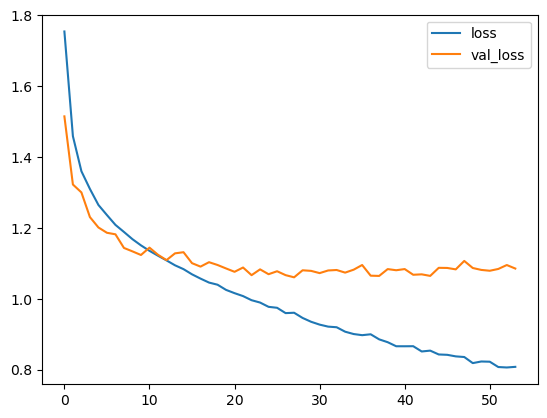

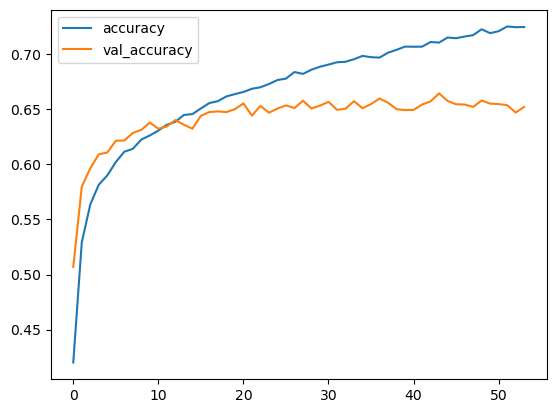

In [72]:
metrics_df = pd.DataFrame(training.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();# The semicolon prevents certain matplotlib items from being printed.

In [73]:
print(training.history)

{'loss': [1.7541546821594238, 1.4588408470153809, 1.3599202632904053, 1.3099476099014282, 1.2647281885147095, 1.2362563610076904, 1.208518624305725, 1.1886018514633179, 1.1682015657424927, 1.1507530212402344, 1.135370135307312, 1.1215671300888062, 1.1083848476409912, 1.094515085220337, 1.0836725234985352, 1.0690419673919678, 1.0569885969161987, 1.0457618236541748, 1.0397602319717407, 1.0251535177230835, 1.015906810760498, 1.0076419115066528, 0.9960517883300781, 0.9894176721572876, 0.9773253798484802, 0.9746485352516174, 0.9596388339996338, 0.9606544375419617, 0.945979118347168, 0.9351549744606018, 0.9271653294563293, 0.921506404876709, 0.9197524189949036, 0.9071921706199646, 0.9005799293518066, 0.8973842263221741, 0.8998878598213196, 0.8855746984481812, 0.877571702003479, 0.8661367297172546, 0.8660954236984253, 0.8662713170051575, 0.8514167070388794, 0.8537812232971191, 0.8429762721061707, 0.84196937084198, 0.8375821709632874, 0.8357699513435364, 0.8185845613479614, 0.8231419920921326,

In [74]:
y_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
track_id,,,,,,,,,,,,,,,,
1951,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60081,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25806,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115469,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116338,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
63862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
608,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
test_loss, test_acc = CNN.evaluate(x_test,y_test)

155/155 [==============================] - 2s 11ms/step - loss: 1.1152 - accuracy: 0.6490


In [76]:
test_acc

0.6489919424057007